# Import Libraries

In [1]:
from gurobipy import *
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pysd
import pandas as pd
import numpy as np
import geopandas as gp
import zipfile
import requests
import networkx as nx
import matplotlib.cm
import math
from math import radians, sin, cos, acos
from geopy.distance import geodesic
import requests
from bs4 import BeautifulSoup
from osgeo import ogr, osr
import matplotlib.cm as cmx
import matplotlib.colors as colors
from Circles.circles import circle
from shapely.geometry import Polygon, Point
from descartes import PolygonPatch
from shapely.ops import cascaded_union
import pickle
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
import datacompy
import warnings
warnings.filterwarnings("ignore")


# Import Input Data (Model Parameters)

In [2]:
with open('Case1DataParameters', 'rb') as fp:
    mhi = pickle.load(fp)
    chi = pickle.load(fp)
    Qi = pickle.load(fp)
    uio = pickle.load(fp)
    cio = pickle.load(fp)
    capi = pickle.load(fp)
    xiiinit = pickle.load(fp)
    B = pickle.load(fp)
    Pi = pickle.load(fp)
    Tcost = pickle.load(fp)

with open('Case1compDPs', 'rb') as fp:
    compDPslist = pickle.load(fp)
    compviablelist = pickle.load(fp)

with open('Case1Fijlist', 'rb') as fp:
    compFijlist = pickle.load(fp)

with open('Case1compcij', 'rb') as fp:
    compcijlist = pickle.load(fp)

with open('Case1compmij', 'rb') as fp:
    compmijlist = pickle.load(fp)



In [3]:
DPslist = compDPslist[-1][:1]
cijlist = compcijlist[-1][:1]
Fijlist = compFijlist[-1][:1]
mijlist = compmijlist[-1][:1]
period = 0

In [6]:
DPslist[0].ActualDemand.sum()

85716.0

In [4]:
Fijlist[0] = Fijlist[0]*0+1000

In [29]:
with open('ResultCase1REL', 'rb') as fp:
    ADFlist = pickle.load(fp)
    BDFlist = pickle.load(fp)
    BDF2list = pickle.load(fp)
    keylist = pickle.load(fp)
    Qilist = pickle.load(fp)
    Tcostlist = pickle.load(fp)
    xiiinitlist = pickle.load(fp)
    Pilist = pickle.load(fp)
    yijmasterlist = pickle.load(fp)
    yhimasterlist = pickle.load(fp)
    extratimelist = pickle.load(fp)
    preptimelist = pickle.load(fp)

In [21]:
keylist

[0, 0, 0, 0, 1, 8, 0, 2, 2]

In [30]:
yhinew = yhimasterlist[-1].copy()

In [ ]:
aa = ADFlist[-6].iloc[keylist[-6],:]
aa = aa.iloc[8:]

In [ ]:
aa

In [ ]:
yhinew = yhitemplate.copy()
yhinew.iloc[20,:] = aa
yhinew.iloc[20,20] = 0

In [9]:
# yhinew = yhitemplate

In [31]:
yhilist.append(yhinew)

In [32]:
len(yhilist)

6

In [12]:
yhilist

[     0    1    2       3    4    5    6    7    8    9    10   11   12   13  \
 0   0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
 1   0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
 2   0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
 3   0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
 4   0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
 5   0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
 6   0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
 7   0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
 8   0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
 9   0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
 10  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
 11  0.0  0.0  0.0     0.0  0.0  0.0  0.

## Extract Additional Parameters

In [5]:
def runmodelA(DPslist, mhi, chi, Qi, uio, cio, capi, xiiinit, cijlist, mijlist, Fijlist, B, Pi, solutionnumber, Tcost, period):
    DPs = DPslist[solutionnumber]
    LDC = DPs.copy()
    Si = DPs.loc[:,'Supply']
    Dj = DPs.loc[:,'ActualDemand']
    Fij = Fijlist[solutionnumber]
    cij = cijlist[solutionnumber]
    mij = mijlist[solutionnumber]

    m = Model()

    # Add variables


    yhi = {} #flow of goods between supply nodes
    xii = {} #binary value equal to 1 if supply node i is to be opened for pre-positioning
    yij = {} #flow of goods from supply node i to demand node j
    xij = {} #Binary variable equal to 1 if demand node j is allocated to supply node i
    Fi = {} #maximum prepositioning time at supply node i

    #define yhi as integer
    for h in range(len(LDC)):
        for i in range(len(LDC)):
            yhi[(h,i)] = m.addVar(lb=0, vtype=GRB.INTEGER)

    #define xii as binary
    for i in range(len(LDC)):
        xii[i] = m.addVar(vtype=GRB.BINARY)

    #define yij as integer
    for i in range(len(LDC)):
          for j in range(len(DPs)):
                yij[(i,j)] = m.addVar(lb=0, vtype=GRB.INTEGER)

    #define xij as binary
    for i in range(len(LDC)):
          for j in range(len(DPs)):
                xij[(i,j)] = m.addVar(lb=0, vtype=GRB.BINARY)

    #define Fi as integer 
    for i in range(len(LDC)):
        Fi[i] = m.addVar(lb=0, vtype=GRB.INTEGER)

    m.update()

#     4 Ensures that the total number of supply nodes is maximum of p
#     m.addConstr(quicksum(xii[i] for i in range(len(LDC))) <= p)

    #5 ensures flow at node j from all supply nodes is not greater than amount demanded at j
    for j in range(len(DPs)):
        m.addConstr(quicksum(yij[(i,j)] for i in range(len(LDC))) <= Dj[j])

    #6 j is only assigned to i if goods can be delivered from i to j withink K hours
    for i in range(len(LDC)):
        for j in range(len(DPs)):
            m.addConstr(xij[(i,j)] <= xii[i])

    # ensures that if i is assigned to j, that the maximum pre-positioning time at i takes into account the amount of time before the typhoon reaches j
    for i in range(len(LDC)):
        for j in range(len(DPs)):
                m.addConstr(Fi[i] <= (1-xij[(i,j)])*Fij.iloc[i,i] + xij[(i,j)]*Fij.iloc[i,j])

    #7 Ensures that goods can only be prepositioned at i if the time needed for pre-position does not exceed the maximum pre-positioning time allowed at i
    for h in range(len(LDC)):
          for i in range(len(LDC)):
                m.addConstr(mhi.iloc[h,i]*xii[i] +
                            (1-xiiinit.iloc[i,0])*xii[i]*uio 
                            <= 
                            Fi[i]
                           )


    #8 Ensures that there is enough quantity of supply at node i to deliver to node j
    for i in range(len(LDC)):
        m.addConstr(quicksum(yij[(i,j)] for j in range(len(DPs))) 
                    <=
                    Qi.iloc[i,0] 
                    +
                    quicksum(yhi[(h,i)] for h in range(len(LDC))) 
                    -
                    quicksum(yhi[(i,h)] for h in range(len(LDC))) 
                    )

    #9 Ensures that the quantity of goods delivered from LDC i to DPs does not exceed the capacity of the LDC
    for i in range(len(LDC)):
        m.addConstr(xii[i]*capi.iloc[i,0]                
                            >= quicksum(yij[(i,j)] for j in range(len(DPs))))

    #10 Ensures that DP j is served only if j is allocated to i
    for i in range(len(LDC)):
        for j in range(len(DPs)):
            m.addConstr(yij[(i,j)] <= 1000000 * xij[(i,j)])

#     #11 Ensures the path is selected for delivery from LDC to DPs is available based on the forecast
#     for i in range(len(LDC)):
#         for j in range(len(DPs)):
#             m.addConstr(xij[(i,j)] <= Rij.iloc[i,j])

    #12 Ensures that supply node h has the quantity needed to deliver to supply node i
    for i in range(len(LDC)):
        m.addConstr(quicksum(yhi[(i,h)] for h in range(len(LDC))) <= Qi.iloc[i,0])
    
    #Ensures that no supply goods are pre-positioned to permanently placed goods
    for h in range(len(LDC)):
        for i in range(len(LDC)):
            m.addConstr(yhi[(i,h)] <= 1000000*(1-Pi.iloc[i,0])*(1-Pi.iloc[h,0]))

    #Ensures that no supply is prepositioned to a node that is potentially destroyed
    for i in range(len(LDC)):
        m.addConstr(quicksum(yhi[(h,i)] for h in range(len(LDC))) <= 1000000*(Si[i]))  
    
    #11 Ensures the path is selected for delivery from LDC to DPs is available based on the forecast
    for i in range(len(LDC)):
        for j in range(len(DPs)):
            m.addConstr(xij[(i,j)] <= (Si[i]))
    
#     #Ensures that the used budget is less than B
#     m.addConstr(quicksum(quicksum(
#                     chi.iloc[h,i]*yhi[(h,i)]
#                     for i in range(len(LDC))) for h in range(len(LDC))) 
#                     +
#                     quicksum(
#                     (1-xiiinit.iloc[i,0])*xii[i]*cio 
# #                         + 
# #                     xiiinit.iloc[i,0]*(1-xii[i])*cic
#                     for i in range(len(LDC)))
#                     +
#                     quicksum(quicksum(
#                     cij.iloc[i,j]*yij[(i,j)]
#                     for i in range(len(LDC))) for j in range(len(LDC))) + Tcost <= B)
        
    m.setParam("MIPGap", 1e-8)
    m.setParam("TimeLimit", 5.0)
    m.setParam("NodefileStart", 0.05)
    # #Set Objective Functions
    # Objective Function 1 Min Costs
    m.setObjectiveN(quicksum(quicksum(
                    chi.iloc[h,i]*yhi[(h,i)]
                    for i in range(len(LDC))) for h in range(len(LDC))) 
                    +
                    quicksum(
                    (1-xiiinit.iloc[i,0])*xii[i]*cio 
#                         + 
#                     xiiinit.iloc[i,0]*(1-xii[i])*cic
                    for i in range(len(LDC)))
                    +
                    quicksum(quicksum(
                    cij.iloc[i,j]*yij[(i,j)]
                    for i in range(len(LDC))) for j in range(len(LDC)))
                    , 
                    index=1, priority=1, weight=1 )

    #Objective Function 2 Min Supply Destroyed
    m.setObjectiveN(quicksum(quicksum(yij[(i,j)]*(mij.iloc[i,j])
                    for i in range(len(LDC))) for j in range(len(DPs))), 
                    index=2, priority=2, weight=1 )

    #Objective Function 3 Max Demand Supplied
    m.setObjectiveN(quicksum(quicksum(yij[(i,j)] 
                    for i in range(len(LDC))) for j in range(len(DPs))), 
                    index=3, priority=3, weight=-1)


    m.optimize()

    variablelist = m.getVars()
    variablelist = [i.x for i in variablelist]

    yhi = pd.DataFrame(np.array(variablelist[:len(DPs)**2]).reshape(len(DPs),len(DPs)))
    xii = pd.DataFrame(variablelist[len(DPs)**2:len(DPs)**2+len(DPs)])
    yij = pd.DataFrame(np.array(variablelist[len(DPs)**2+len(DPs):len(DPs)**2+len(DPs)+len(DPs)**2]).reshape(len(DPs),len(DPs)))
    xij = pd.DataFrame(np.array(variablelist[len(DPs)**2+len(DPs)+len(DPs)**2:len(DPs)**2+len(DPs)+len(DPs)**2+len(DPs)**2]).reshape(len(DPs),len(DPs)))
    Fi = pd.DataFrame(variablelist[len(DPs)**2+len(DPs)+len(DPs)**2+len(DPs)**2:])

    pd.set_option('display.max_columns', None)  
    yhi2 = yhi[(yhi.T != 0).any()]
    xii2 = xii[(xii.T != 0).any()]
    yij2 = yij[(yij.T != 0).any()]
    xij2 = xij[(xij.T != 0).any()]
    Fi2 = Fi[(Fi.T != 0).any()]
    
    costA = yij.copy()
    costB = yhi.copy()
    dyij = yij.copy()
    dist = yij.copy()
    for i in range(len(dyij)):
        for j in range(len(dyij)):
            dyij.iloc[i,j] = yij.iloc[i,j]*(1-Si[i])
            costA.iloc[i,j] = chi.iloc[i,j]*yhi.iloc[i,j] + cij.iloc[i,j]*yij.iloc[i,j]
            dist.iloc[i,j] = yij.iloc[i,j]*mij.iloc[i,j]
            costB.iloc[i,j] = int(yhi.iloc[i,j]/7500)*cio
#     for i in range(len(costB)):
#         costB.iloc[i,0] = (1-xiiinit.iloc[i,0])*xii.iloc[i,0]*cio
    
    Qinew = Qi.copy()
    DD = Qi.copy()
    for i in range(len(Qinew)):
        Qinew.iloc[i,0] = Qi.iloc[i,0] - yhi.sum(axis=1)[i] + yhi.sum(axis=0)[i]
        DD.iloc[i,0] = Qinew.iloc[i,0]*(1-Si[i])
    
    if yij.sum().sum() == 0:
        avedist = 0
    else:
        avedist = dist.sum().sum()/yij.sum().sum()
        
    
    listA = pd.DataFrame(np.zeros((1, 0)))
    listA['Period'] = period
    listA['Solution'] = solutionnumber
    listA['Demand'] = Dj.sum()
    listA['SuppliedDemand'] = yij.sum().sum()
    listA['DestroyedDemand'] = DD.sum().sum()
    listA['AverageResponseTime'] = avedist
    listA['Cost'] = Tcost + costA.sum().sum() + costB.sum().sum()
    listA['LDC'] = xii.sum() - 1
    listA = pd.concat([listA, Qinew.T], axis=1)
    return listA, yhi, xii, yij, xij, Fi 

In [6]:
yhilist = list()
xiilist = list()
yijlist = list()
xijlist = list()
Filist = list()
for solutionnumber in range(len(DPslist)):
    if solutionnumber == 0:
        ADF, yhi, xii, yij, xij, Fi = runmodelA(DPslist, mhi, chi, Qi, uio, cio, capi, xiiinit, cijlist, mijlist, Fijlist, B, Pi, solutionnumber, Tcost, period)
    else:
        ADFnew, yhi, xii, yij, xij, Fi = runmodelA(DPslist, mhi, chi, Qi, uio, cio, capi, xiiinit, cijlist, mijlist, Fijlist, B, Pi, solutionnumber, Tcost, period)
        ADF = ADF.append(ADFnew)
    yhilist.append(yhi)
    xiilist.append(xii)
    yijlist.append(yij)
    xijlist.append(xij)
    Filist.append(Fi)
ADF = ADF.reset_index(drop = True)

Changed value of parameter MIPGap to 1e-08
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Changed value of parameter TimeLimit to 5.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Changed value of parameter NodefileStart to 0.05
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 11836 rows, 5896 columns and 30931 nonzeros
Variable types: 0 continuous, 5896 integer (1980 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+06]
  Objective range  [2e-02, 3e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 4 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 9389 rows and 3463 columns
Presolve time: 0.03s
Presol

In [7]:
ADF

,Period,Solution,Demand,SuppliedDemand,DestroyedDemand,AverageResponseTime,Cost,LDC,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
0,0,0,85716.0,30000.0,0.0,0.0,88955.37644,6.0,0.0,0.0,0.0,2457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4059.0,3335.0,0.0,0.0,0.0,0.0,0.0,5815.0,6899.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7435.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
yhitemplate = yhilist[0]*0

In [58]:
def runmodelB(DPslist, mhi, chi, Qi, uio, cio, capi, xiiinit, cijlist, mijlist, Fijlist, B, solutionnumber, scenarionumber, period, yhilist, Tcost):

    DPs = DPslist[scenarionumber]
    LDC = DPs.copy()
    Si = DPs.loc[:,'Supply']
    Dj = DPs.loc[:,'ActualDemand']
    Fij = Fijlist[scenarionumber]
    cij = cijlist[scenarionumber]
    mij = mijlist[scenarionumber]
    yhi = yhilist[solutionnumber]

    


    m = Model()


    # Add variables


    xii = {} #binary value equal to 1 if supply node i is to be opened for pre-positioning
    yij = {} #flow of goods from supply node i to demand node j
    xij = {} #Binary variable equal to 1 if demand node j is allocated to supply node i
    Fi = {} #maximum prepositioning time at supply node i

    #define xii as binary
    for i in range(len(LDC)):
        xii[i] = m.addVar(vtype=GRB.BINARY)

    #define yij as integer
    for i in range(len(LDC)):
          for j in range(len(DPs)):
                yij[(i,j)] = m.addVar(lb=0, vtype=GRB.INTEGER)

    #define xij as binary
    for i in range(len(LDC)):
          for j in range(len(DPs)):
                xij[(i,j)] = m.addVar(lb=0, vtype=GRB.BINARY)

    #define Fi as integer 
    for i in range(len(LDC)):
        Fi[i] = m.addVar(lb=0, vtype=GRB.INTEGER)

    m.update()


    #5 ensures flow at node j from all supply nodes is not greater than amount demanded at j
    for j in range(len(DPs)):
        m.addConstr(quicksum(yij[(i,j)] for i in range(len(LDC))) <= Dj[j])

    #6 j is only assigned to i if goods can be delivered from i to j withink K hours
    for i in range(len(LDC)):
        for j in range(len(DPs)):
            m.addConstr(xij[(i,j)] <= xii[i])

    # ensures that if i is assigned to j, that the maximum pre-positioning time at i takes into account the amount of time before the typhoon reaches j
    for i in range(len(LDC)):
        for j in range(len(DPs)):
                m.addConstr(Fi[i] <= (1-xij[(i,j)])*Fij.iloc[i,i] + xij[(i,j)]*Fij.iloc[i,j])

    #7 Ensures that goods can only be prepositioned at i if the time needed for pre-position does not exceed the maximum pre-positioning time allowed at i
    for h in range(len(LDC)):
          for i in range(len(LDC)):
                m.addConstr( 
                            mhi.iloc[h,i]*xii[i] +
                            (1-xiiinit.iloc[i,0])*xii[i]*uio 
                            <= 
                            Fi[i]
                           )


    #8 Ensures that there is enough quantity of supply at node i to deliver to node j
    for i in range(len(LDC)):
        m.addConstr(quicksum(yij[(i,j)] for j in range(len(DPs))) 
                    <=
                    Qi.iloc[i,0] - yhi.sum(axis=1)[i] + yhi.sum(axis=0)[i]
                    )

    #9 Ensures that the quantity of goods delivered from LDC i to DPs does not exceed the capacity of the LDC
    for i in range(len(LDC)):
        m.addConstr(xii[i]*capi.iloc[i,0]                
                            >= quicksum(yij[(i,j)] for j in range(len(DPs))))

    #10 Ensures that DP j is served only if j is allocated to i
    for i in range(len(LDC)):
        for j in range(len(DPs)):
            m.addConstr(yij[(i,j)] <= 1000000 * xij[(i,j)])

    #11 Ensures the path is selected for delivery from LDC to DPs is available based on the forecast
    for i in range(len(LDC)):
        for j in range(len(DPs)):
            m.addConstr(xij[(i,j)] <= (Si[i]))
    

            
    m.setParam("MIPGap", 1e-8)
    m.setParam("TimeLimit", 5.0)
    m.setParam("NodefileStart", 0.05)
    # #Set Objective Functions
#     Objective Funciton 1 Min Costs
    m.setObjectiveN(quicksum(quicksum(
                    chi.iloc[h,i]*yhi.iloc[h,i]
                    for i in range(len(LDC))) for h in range(len(LDC))) 
                    +
#                     quicksum(
#                     (1-xiiinit.iloc[i,0])*xii[i]*cio 
#                     for i in range(len(LDC)))
                    quicksum(quicksum(
                    yhi.iloc[h,i]/7500
                    for i in range(len(LDC))) for h in range(len(LDC))) *cio
                    +
                    quicksum(quicksum(
                    cij.iloc[i,j]*yij[(i,j)]
                    for i in range(len(LDC))) for j in range(len(LDC)))
                    , 
                    index=1, priority=1, weight=1 )

    #Objective Function 2 Min Supply Destroyed
    m.setObjectiveN(quicksum(quicksum(yij[(i,j)]*(mij.iloc[i,j])
                    for i in range(len(LDC))) for j in range(len(DPs))), 
                    index=2, priority=2, weight=1 )

    #Objective Function 3 Max Demand Supplied
    m.setObjectiveN(quicksum(quicksum(yij[(i,j)] 
                    for i in range(len(LDC))) for j in range(len(DPs))), 
                    index=3, priority=3, weight=-1)



    m.optimize()

    variablelist = m.getVars()
    variablelist = [i.x for i in variablelist]

    xii = pd.DataFrame(variablelist[:len(DPs)])
    yij = pd.DataFrame(np.array(variablelist[len(DPs):len(DPs)+len(DPs)**2]).reshape(len(DPs),len(DPs)))
    xij = pd.DataFrame(np.array(variablelist[len(DPs)+len(DPs)**2:+len(DPs)+len(DPs)**2+len(DPs)**2]).reshape(len(DPs),len(DPs)))
    Fi = pd.DataFrame(variablelist[len(DPs)+len(DPs)**2+len(DPs)**2:])

    pd.set_option('display.max_columns', None)  
    yhi2 = yhi[(yhi.T != 0).any()]
    xii2 = xii[(xii.T != 0).any()]
    yij2 = yij[(yij.T != 0).any()]
    xij2 = xij[(xij.T != 0).any()]
    Fi2 = Fi[(Fi.T != 0).any()]

    costA = yij.copy()
    costB = xiiinit.copy()
    dyhi = Si.copy()
    dist = yij.copy()
    for i in range(len(LDC)):
        for j in range(len(DPs)):
            #costA is the cost of transferring between supply nodes (h to i) and from supply nodes to demand nodes (i to j)
            costA.iloc[i,j] = chi.iloc[i,j]*yhi.iloc[i,j] + cij.iloc[i,j]*yij.iloc[i,j]
            dist.iloc[i,j] = yij.iloc[i,j]*mij.iloc[i,j]*60
#             costB.iloc[i,j] = int(yhi.iloc[i,j]/7500)*cio
            
    for i in range(len(LDC)):
#         costB is the cost of setup (and closure) and opened and closed nodeds
        costB.iloc[i,0] = (1-xiiinit.iloc[i,0])*xii.iloc[i,0]*cio 
#         + xiiinit.iloc[i,0]*(1-xii.iloc[i,0])*cic
        dyhi[i] = (1-Si[i])*yhi.sum(axis=0)[i]

    Qinew = Qi.copy()
    DD = Qi.copy()
    for i in range(len(Qinew)):
        Qinew.iloc[i,0] = Qi.iloc[i,0] - yhi.sum(axis=1)[i] + yhi.sum(axis=0)[i]
        DD.iloc[i,0] = Qinew.iloc[i,0]*(1-Si[i])
    
    
    if yij.sum().sum() == 0:
        avedist = 0
    else:
        avedist = dist.sum().sum()/yij.sum().sum()
    
    listA = pd.DataFrame(np.zeros((1, 0)))
    listA['Period'] = period
    listA['Scenario'] = scenarionumber
    listA['Solution'] = solutionnumber
#     listA['Demand'] = Dj.sum()
    listA['% Demand Supplied'] = yij.sum().sum() / min(Qi.sum().sum(),Dj.sum()) * 100
    listA['% Demand Destroyed'] = DD.sum().sum()
    listA['Average Travel Time (min)'] = avedist
    listA['Cost'] = Tcost + costA.sum().sum() + costB.sum()
    listA['Facilities'] = xii.sum()
#     listA = pd.concat([listA, Qinew.T], axis=1)
    
    return listA



In [59]:
for scenarionumber in [0]:
    for solutionnumber in range(len(yhilist)):
        if solutionnumber == 0 and scenarionumber == 0:
            BDF = runmodelB(DPslist, mhi, chi, Qi, uio, cio, capi, xiiinit, cijlist, mijlist, Fijlist, B, solutionnumber, scenarionumber, period, yhilist, Tcost)
        else:
            BDF = BDF.append(runmodelB(DPslist, mhi, chi, Qi, uio, cio, capi, xiiinit, cijlist, mijlist, Fijlist, B, solutionnumber, scenarionumber, period, yhilist, Tcost))



Changed value of parameter MIPGap to 1e-08
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Changed value of parameter TimeLimit to 5.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Changed value of parameter NodefileStart to 0.05
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 9812 rows, 3960 columns and 21339 nonzeros
Variable types: 0 continuous, 3960 integer (1980 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+06]
  Objective range  [2e-02, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+03]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 4 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 8062 rows and 2200 columns
Presolve time: 0.03s
Presolv

Optimize a model with 9812 rows, 3960 columns and 21339 nonzeros
Variable types: 0 continuous, 3960 integer (1980 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+06]
  Objective range  [2e-02, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+04]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 4 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 8204 rows and 2310 columns
Presolve time: 0.02s
Presolved: 1608 rows and 1650 columns
---------------------------------------------------------------------------

Multi-objectives: optimize objective 1 () ...
---------------------------------------------------------------------------

Found heuristic solution: objective 0.0000000
Presolve removed 1608 rows 


Presolve removed 8158 rows and 2288 columns
Presolve time: 0.02s
Presolved: 1654 rows and 1672 columns
---------------------------------------------------------------------------

Multi-objectives: optimize objective 1 () ...
---------------------------------------------------------------------------

Found heuristic solution: objective 0.0000000
Presolve removed 1630 rows and 1628 columns
Presolve time: 0.00s
Presolved: 24 rows, 44 columns, 88 nonzeros
Variable types: 0 continuous, 44 integer (0 binary)

Root relaxation: objective -3.000000e+04, 28 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    -30000.00000 -30000.000  0.00%     -    0s

Explored 0 nodes (28 simplex iterations) in 0.06 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: -30000 0 

Optimal solution found (tolerance 1.00e-08)
Best objecti

In [60]:
BDF = BDF.reset_index(drop=True)
BDF

,Period,Scenario,Solution,% Demand Supplied,% Demand Destroyed,Average Travel Time (min),Cost,Facilities
0,0,0,0,100.0,0.0,0.000000,286955.37644,6.0
1,0,0,1,100.0,0.0,44.664337,84549.58931,1.0
2,0,0,2,100.0,0.0,44.664337,84549.58931,1.0
3,0,0,3,100.0,0.0,44.664337,84549.58931,1.0
4,0,0,4,100.0,0.0,36.438777,120879.22487,2.0
5,0,0,5,100.0,0.0,17.700300,219975.70477,5.0


In [62]:
# writer = pd.ExcelWriter('Case1_Final.xlsx')
# BDF.to_excel(writer,'Sheet1')

In [549]:
resultDPs = DPslist[0].copy()

In [550]:
DPslist[0].ActualDemand.sum()

85716.0

In [551]:
yij.sum()

0     4563.0
1        0.0
2     2673.0
3     2457.0
4     3012.0
5     2977.0
6        0.0
7     3876.0
8     1957.0
9     1319.0
10       0.0
11    4971.0
12    6311.0
13    3925.0
14    4059.0
15    3335.0
16       0.0
17    4231.0
18       0.0
19       0.0
20       0.0
21    5815.0
22    6899.0
23       0.0
24    2628.0
25       0.0
26       0.0
27       0.0
28       0.0
29       0.0
30       0.0
31    8023.0
32       0.0
33       0.0
34    3403.0
35    3268.0
36       0.0
37       0.0
38    1427.0
39       0.0
40    4587.0
41       0.0
42       0.0
43       0.0
dtype: float64

In [552]:
resultDPs['AmtSupply'] = yhi.sum()
resultDPs.loc[20,'AmtSupply'] = Qi.loc[20,0] - yhi.sum().sum()
resultDPs['AmtSupplysize'] = resultDPs['AmtSupply']/10000*30+0.0000001
resultDPs['AmtRecvd'] = yij.sum()
resultDPs['AmtRecvdsize'] = resultDPs['AmtRecvd']/10000*30+0.0000001
resultDPs['Facility'] = xii
resultDPs.loc[20,'Facility']=0
supplyDPs = resultDPs[resultDPs['Facility']==1].reset_index(drop=True)
rdc = resultDPs.loc[20,:]

In [553]:
resultDPs

,Municipality,Code,latitude,longitude,Population,ActualDemand,Supply,PrepTime,AmtSupply,AmtSupplysize,AmtRecvd,AmtRecvdsize,Facility
0,AJUY,63001000,11.153148,123.016039,47248,4563.0,0,0,0.0,1.000000e-07,4563.0,1.368900e+01,0.0
1,ALIMODIAN,63002000,10.853345,122.389006,37484,0.0,1,1000,0.0,1.000000e-07,0.0,1.000000e-07,0.0
2,ANILAO,63003000,10.989395,122.736612,27486,2673.0,1,0,2673.0,8.019000e+00,2673.0,8.019000e+00,1.0
3,BADIANGAN,63004000,10.989827,122.537240,26218,2457.0,1,0,2457.0,7.371000e+00,2457.0,7.371000e+00,1.0
4,BALASAN,63005000,11.457487,123.083696,29724,3012.0,0,0,0.0,1.000000e-07,3012.0,9.036000e+00,0.0
5,BANATE,63006000,11.029681,122.801587,29543,2977.0,1,0,2977.0,8.931000e+00,2977.0,8.931000e+00,1.0
6,BAROTAC NUEVO,63007000,10.905421,122.716919,51867,0.0,1,1000,0.0,1.000000e-07,0.0,1.000000e-07,0.0
7,BAROTAC VIEJO,63008000,11.069291,122.857832,41470,3876.0,1,0,8439.0,2.531700e+01,3876.0,1.162800e+01,1.0
8,BATAD,63009000,11.405192,123.105126,19385,1957.0,0,0,0.0,1.000000e-07,1957.0,5.871000e+00,0.0
9,BINGAWAN,63010000,11.188468,122.568007,13432,1319.0,1,0,1319.0,3.957000e+00,1319.0,3.957000e+00,1.0


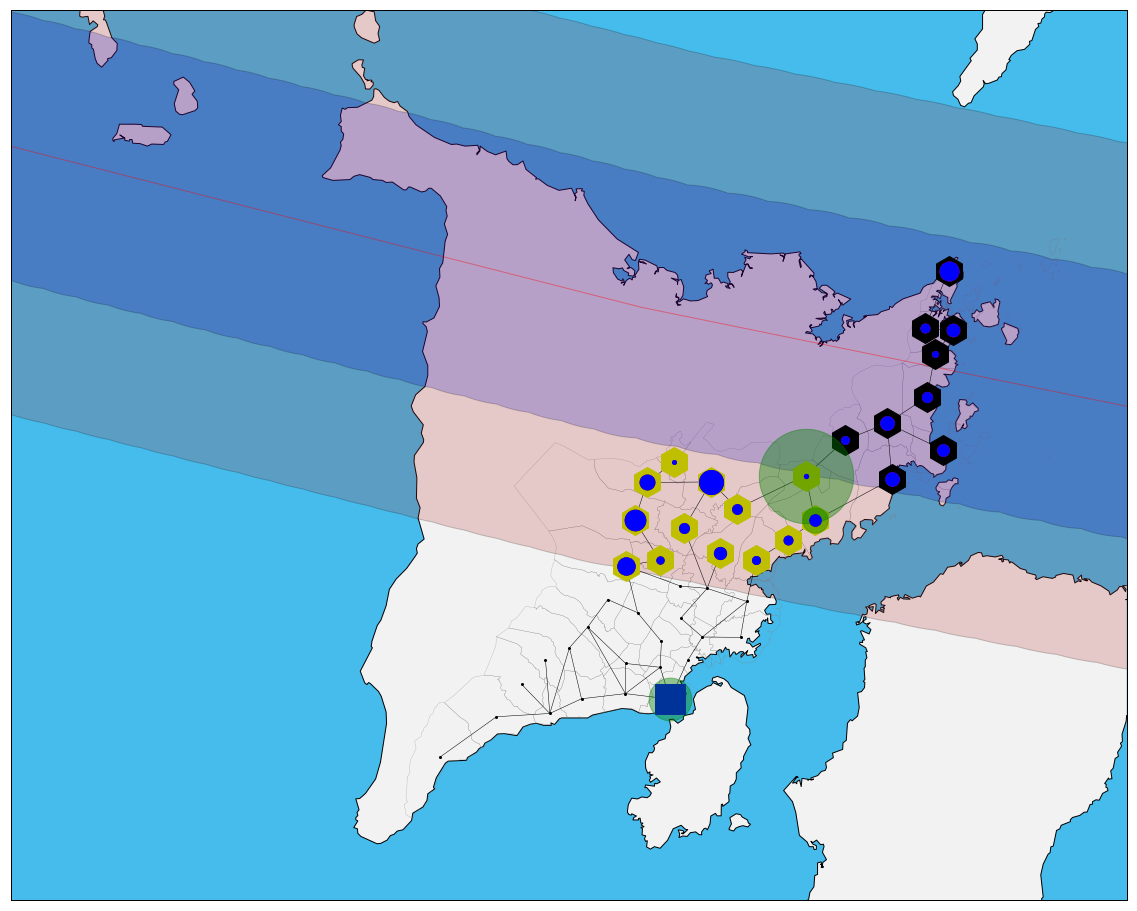

In [554]:
from Circles.circles import circle
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from descartes import PolygonPatch
import numpy as np

#create basemap

lonmin = 121.2
lonmax = 123.5
latmin = 10.3
latmax = 12.1

fig, ax = plt.subplots(figsize=(20,20))
m = Basemap(resolution='h', # c, l, i, h, f or None
            projection='merc',
            llcrnrlon=lonmin, llcrnrlat= latmin, urcrnrlon=lonmax, urcrnrlat=latmax)

#draw best track
besttrackdf = besttrackdf[(besttrackdf[['Latitude','Longitude']] != 0).all(axis=1)]
q,r = m(besttrackdf['Longitude'].tolist(), besttrackdf['Latitude'].tolist())
m.plot(q, r, marker="o", markersize=0.1, linewidth=1, zorder=2, color = 'red', alpha = 0.4)

#generate best track affected area
forecastcone2 = generatebesttrackcone(besttrackdf,30,m)
mapforecastcone2 = PolygonPatch(forecastcone2, fc='#B22222', alpha=0.2, zorder=2)
ax.add_patch(mapforecastcone2)

#generate best track affected area (supply destroyed)
forecastcone3 = generatebesttrackcone2(besttrackdf,30,m)
mapforecastcone3 = PolygonPatch(forecastcone3, fc='#0000CD', alpha=0.2, zorder=2)
ax.add_patch(mapforecastcone3)

#draw map boundaries
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()

#draw town centers
x,y = m(towns['longitude'].tolist(), towns['latitude'].tolist())
m.plot(x, y, 'ko', markersize=2, zorder=3)

#draw town centers demand
a,b = m(visDPs['longitude'].tolist(), visDPs['latitude'].tolist())
c = visDPs['size'].tolist()
for a1, b1, c1 in zip (a,b,c):
    m.plot(a1, b1, 'ro', markersize=c1, zorder=6)

#draw town centers amount supplied
f,g = m(resultDPs['longitude'].tolist(), resultDPs['latitude'].tolist())
h = resultDPs['AmtSupplysize'].tolist()
for as1, bs1, cs1 in zip (f,g,h):
    m.plot(as1, bs1, 'go', markersize=cs1, zorder=6, alpha = 0.4)

#draw town centers amount received
w,x = m(resultDPs['longitude'].tolist(), resultDPs['latitude'].tolist())
y = resultDPs['AmtRecvdsize'].tolist()
for w1, x1, y1 in zip (w,x,y):
    m.plot(w1, x1, 'bo', markersize=y1, zorder=7)

#draw town centers of destroyed supply centers
u,v = m(visDPsdest['longitude'].tolist(), visDPsdest['latitude'].tolist())
m.plot(u, v, 'hk', markersize=30, zorder=4)

#draw supply centers
u,v = m(supplyDPs['longitude'].tolist(), supplyDPs['latitude'].tolist())
m.plot(u, v, 'hy', markersize=30, zorder=4)

#draw RDC
i,j = m(rdc['longitude'], rdc['latitude'].tolist())
m.plot(i, j, 'sb', markersize=30, zorder=4)
#balik

#draw town borders
m.readshapefile('regionvi', "towns", linewidth = 0.2, color='gray')

#draw roads
for i in range(len(roads)):
    roadlon = [roads['startlon'][i],roads['endlon'][i]]
    roadlat = [roads['startlat'][i],roads['endlat'][i]]
    q,r = m(roadlon,roadlat)
    m.plot(q,r, marker=None, linewidth = 0.5, color='black')

In [555]:
# yhitemplate = yhilist[0]*0